In [1]:
import json
import numpy as np
import pandas as pd
import scipy.sparse
import pickle as pkl
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io
import operator

First we load the ingredients and recipes dataframes.

In [2]:
with open('data/dataframes.pkl', 'rb') as f:
    data = pkl.load(f)
    ingredients_df = data['ingredients']
    recipes_df = data['recipes']

In [3]:
display(ingredients_df.head())
display(recipes_df.head())

,name
0,yogurt
1,strawberries
2,cereals ready-to-eat
3,sugars granulated
4,sugars powdered


,name,ingredients,energy,fat,protein,salt,saturates,sugars
0,Yogurt Parfaits,"[(0, 55.41124271920566), (1, 37.13693757085337...",81.129461,2.140139,6.914437,0.055978,0.365347,5.086341
1,"Salt Free, Low Cholesterol Sugar Cookies Recipe","[(3, 13.479389772334713), (6, 22.4656496205578...",477.096404,23.412486,7.625492,0.548621,3.425054,14.298443
2,Honey Sriracha Chicken Wings,"[(7, 0.8547499191680942), (15, 86.157272296732...",208.058983,14.297046,15.383456,1.063915,4.535687,3.048951
3,Shrimp and Caper Salad,"[(7, 6.859617037531474), (53, 57.6197668757032...",194.752596,15.980767,11.946687,0.614843,2.366704,0.314583
4,Natural Peanut Butter Chocolate Bon Bons,"[(50, 36.17929562433298), (60, 9.1782283884738...",457.097118,29.329776,14.049093,0.029883,6.382497,35.608324


Then we are loading the ingredients graph and do some initial exploration

ingredientsGraph[ *ingredientA* ][ *ingredientB* ] = number of times ingredients are encountered together \
recipesGraph[ *recipeA* ][ *recipeB* ] = sum of tf-idf-like terms for shared ingredients

In [4]:
# Load ingredients graph
with open('data/ingredient_graph.pkl', 'rb') as f:
    ingredients_graph_raw = pkl.load(f)

# Load recipes graph
recipes_graph_raw = scipy.sparse.load_npz('data/recipe_graph.npz')

In [5]:
# Make matrices symmetrical
ingredients_graph_raw = ingredients_graph_raw + ingredients_graph_raw.T
recipes_graph_raw = recipes_graph_raw + recipes_graph_raw.transpose()

# Generate networkx graphs
ingredients_graph = nx.from_numpy_matrix(ingredients_graph_raw)
recipes_graph = nx.from_scipy_sparse_matrix(recipes_graph_raw)

In [6]:
print('Ingredients graph')
print(f'Number of nodes: {ingredients_graph.number_of_nodes()}, Number of edges: {ingredients_graph.number_of_edges()}')
print(f'Number of self-loops: {nx.number_of_selfloops(ingredients_graph)}, Number of connected components: {nx.number_connected_components(ingredients_graph)}')
print()
print('Recipes graph')
print(f'Number of nodes: {recipes_graph.number_of_nodes()}, Number of edges: {recipes_graph.number_of_edges()}')
print(f'Number of self-loops: {nx.number_of_selfloops(recipes_graph)}, Number of connected components: {nx.number_connected_components(recipes_graph)}')

Ingredients graph
Number of nodes: 251, Number of edges: 15996
Number of self-loops: 0, Number of connected components: 1

Recipes graph
Number of nodes: 51235, Number of edges: 12785429
Number of self-loops: 0, Number of connected components: 3379


## 1. Ingredient graph
We start by looking at a few characteristics of the ingredient graph.

### 1.1. Degree distribution
First, let's examine the degree distribution of the ingredient graph. We will consider the weighted graph as well as the binary version of it.

Minimum degree in weighted graph is 14.0 for mcdonald's
Maximum degree in weighted graph is 132134.0 for salt
Minimum degree in unweighted graph is 8.0 for mcdonald's
Maximum degree in unweighted graph is 248.0 for water


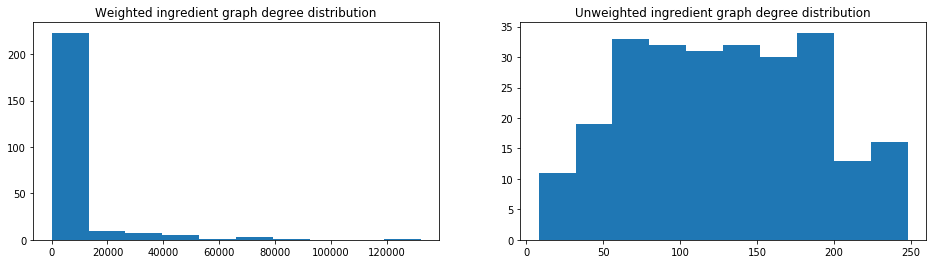

In [7]:
# Form adjacency matrix
ingredients_adj = ingredients_graph_raw.copy()
ingredients_adj[ingredients_adj.nonzero()] = 1

ing_weight_deg = ingredients_graph_raw.sum(axis=1)
ing_adj_deg = ingredients_adj.sum(axis=1)

# Plot degree distributions
_, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Weighted ingredient graph degree distribution')
axes[0].hist(ing_weight_deg)
axes[1].set_title('Unweighted ingredient graph degree distribution')
axes[1].hist(ing_adj_deg);

print(f"Minimum degree in weighted graph is {ing_weight_deg.min()} for {ingredients_df.loc[ing_weight_deg.argmin()]['name']}")
print(f"Maximum degree in weighted graph is {ing_weight_deg.max()} for {ingredients_df.loc[ing_weight_deg.argmax()]['name']}")
print(f"Minimum degree in unweighted graph is {ing_adj_deg.min()} for {ingredients_df.loc[ing_adj_deg.argmin()]['name']}")
print(f"Maximum degree in unweighted graph is {ing_adj_deg.max()} for {ingredients_df.loc[ing_adj_deg.argmax()]['name']}")

In [8]:
ing_weight_deg_vals, ing_weight_deg_counts = np.unique(ing_weight_deg, return_counts=True)
ing_adj_deg_vals, ing_adj_deg_counts = np.unique(ing_adj_deg, return_counts=True)

ing_weight_deg_probs = ing_weight_deg_counts / ing_weight_deg_counts.sum()
ing_adj_deg_probs = ing_adj_deg_counts / ing_adj_deg_counts.sum()

ing_weight_moment_1 = (ing_weight_deg_vals * ing_weight_deg_probs).sum()
ing_weight_moment_2 = (ing_weight_deg_vals**2 * ing_weight_deg_probs).sum()

ing_adj_moment_1 = (ing_adj_deg_vals * ing_adj_deg_probs).sum()
ing_adj_moment_2 = (ing_adj_deg_vals**2 * ing_adj_deg_probs).sum()

print(f'First moment of weighted graph: {ing_weight_moment_1}')
print(f'Second moment of weighted graph: {ing_weight_moment_2}')
print(f'First moment of unweighted graph: {ing_adj_moment_1}')
print(f'Second moment of unweighted graph: {ing_adj_moment_2}')

First moment of weighted graph: 6902.191235059761
Second moment of weighted graph: 274290466.19123507
First moment of unweighted graph: 127.4581673306773
Second moment of unweighted graph: 19792.5577689243


We see that the degree distribution of the adjacency matrix is pretty well spread in the range of all possible values. Moreover, the mean is slightly above half of the number of nodes. The minimum degree of any node is nonzero, so we have no isolated nodes. Also, the maximum degree is almost equal to the number of nodes, so there are ingredients which appear with almost every other ingredient in at least some recipe.

For the weighted graph, we see that most of the degrees fall below 10000, with a mean just below 7000. The spread however is very large. The maximum degree in this case is about 130000, indicating a fairly large number of co-occurences with other ingredients.

Let us also visualize the graph and filter out the weakest connections.

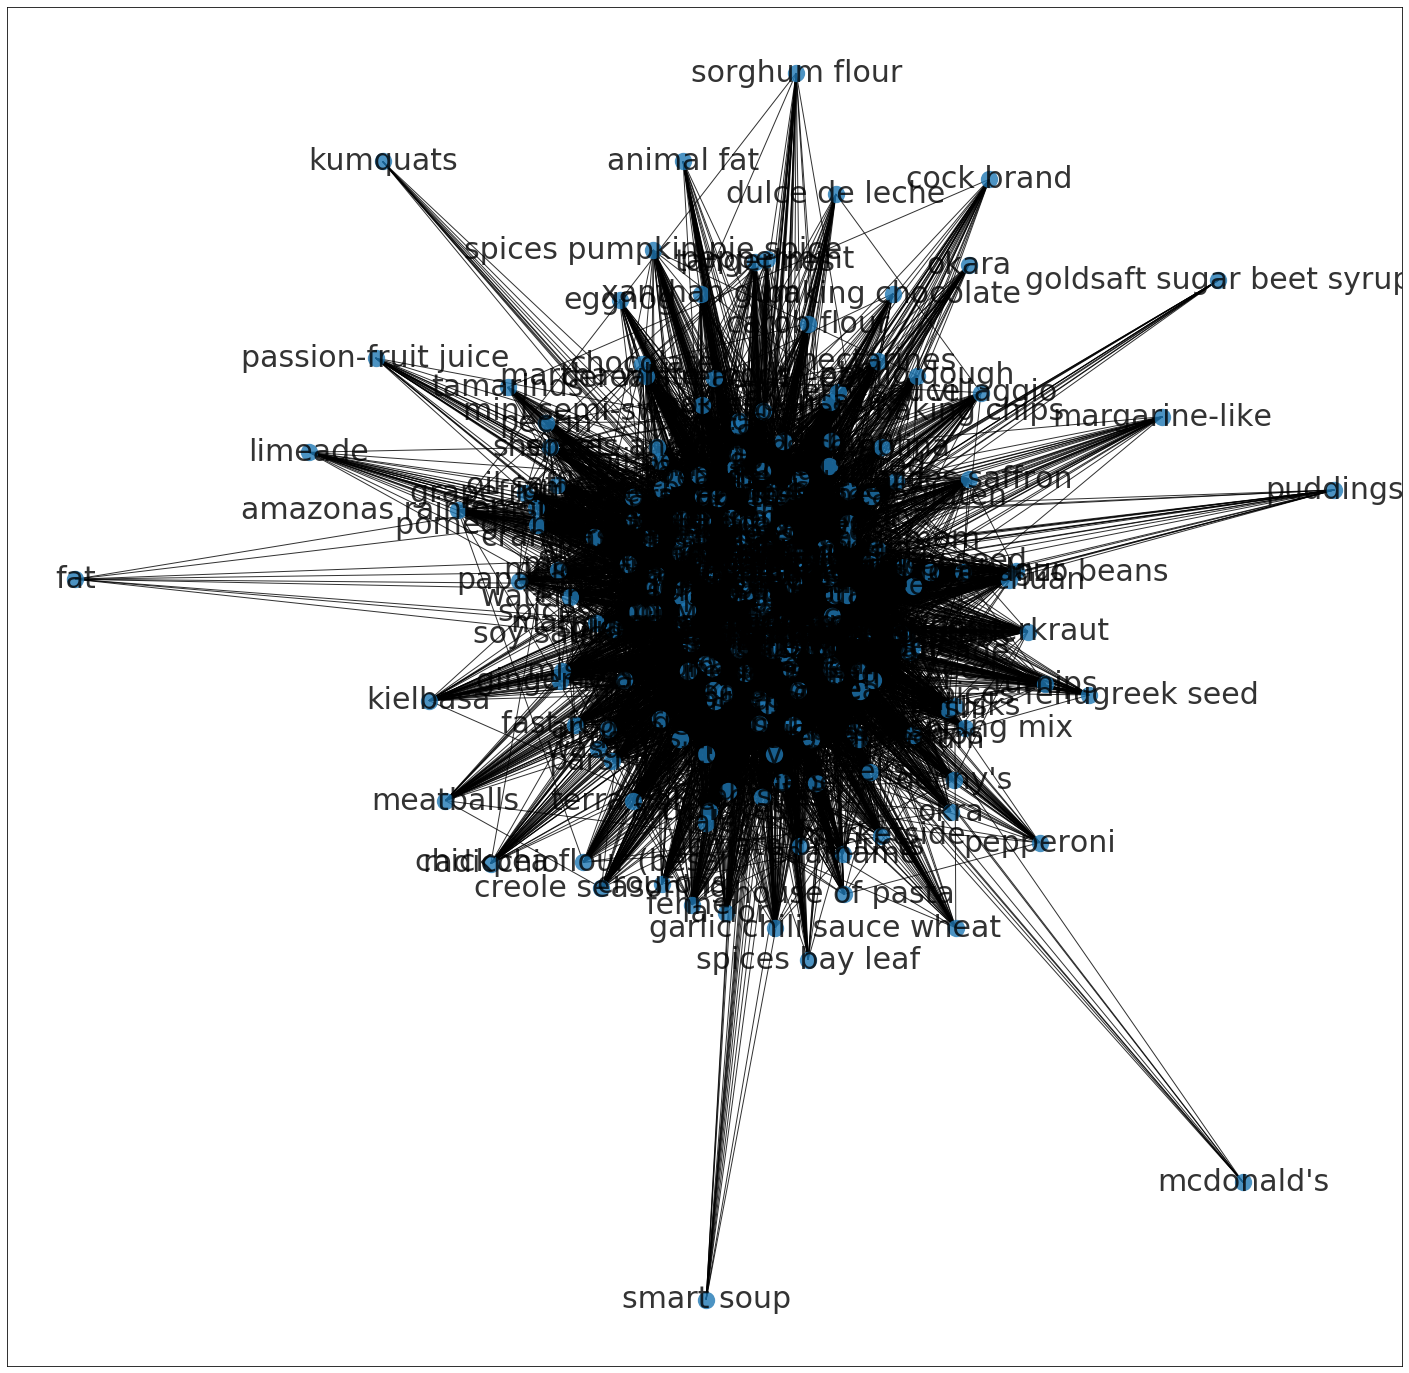

In [9]:
fig, axis = plt.subplots(1, 1, figsize=(25, 25))
nx.draw_networkx(ingredients_graph, ax=axis, labels=ingredients_df.to_dict()['name'], node_size=300, font_size=30, alpha=0.8, linewidths=0.01)

Minimum edge weight: 1.0
Maximum edge weight: 8576.0


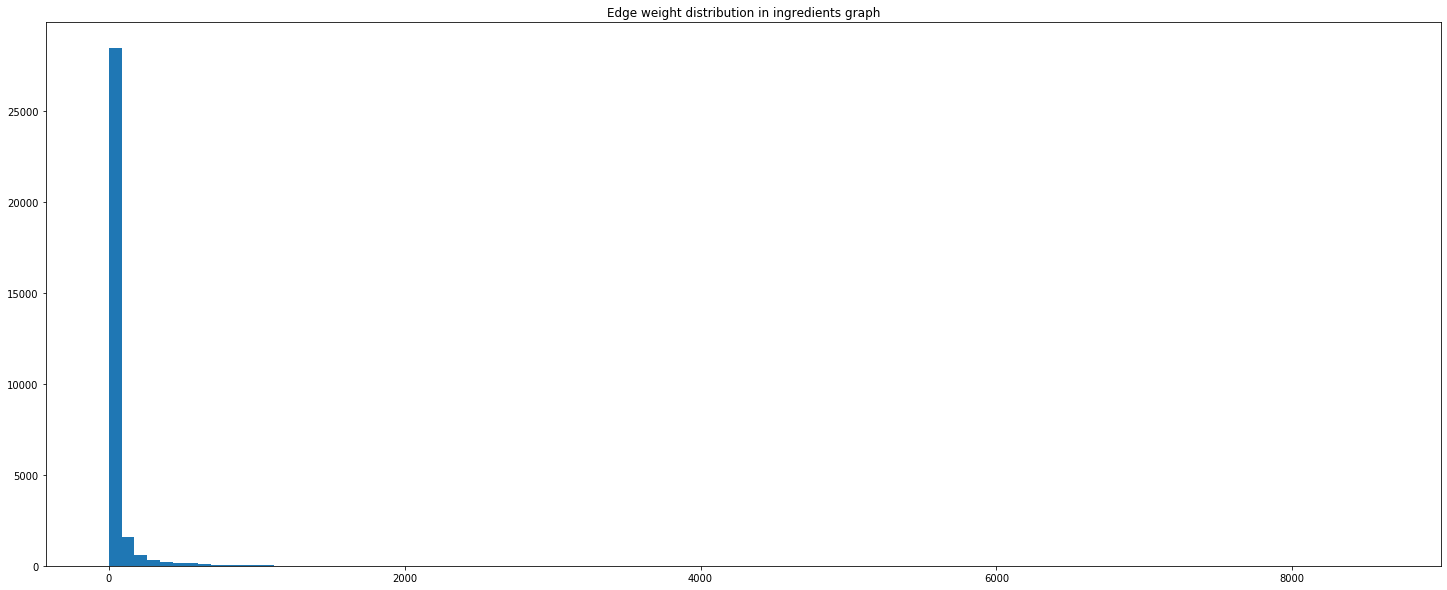

In [10]:
# Plot edge weights histogram
nonzero_edge_weights = ingredients_graph_raw[ingredients_graph_raw.nonzero()]
_, axis = plt.subplots(1, 1, figsize=(25,10))
axis.set_title('Edge weight distribution in ingredients graph')
axis.hist(nonzero_edge_weights, bins=100)

print(f'Minimum edge weight: {nonzero_edge_weights.min()}')
print(f'Maximum edge weight: {nonzero_edge_weights.max()}')

In [11]:
# Determine the top 2% edge weights
print(f'The top 1% edge weights are above {np.percentile(nonzero_edge_weights, 98)}.')

The top 1% edge weights are above 507.3600000000006.


We are going to take only the edges with weight >= 507, the ones providing the most significant connections.

In [12]:
ingredients_graph_raw_top = ingredients_graph_raw.copy()
ingredients_graph_raw_top[ingredients_graph_raw_top < 507] = 0

ingredients_graph_top_weight = nx.from_numpy_matrix(ingredients_graph_raw_top)
all_nodes = set(ingredients_graph_top_weight.nodes)

# Remove isolated nodes
nodes_to_remove = set(list(nx.isolates(ingredients_graph_top_weight)))
nodes_left = all_nodes.difference(nodes_to_remove)

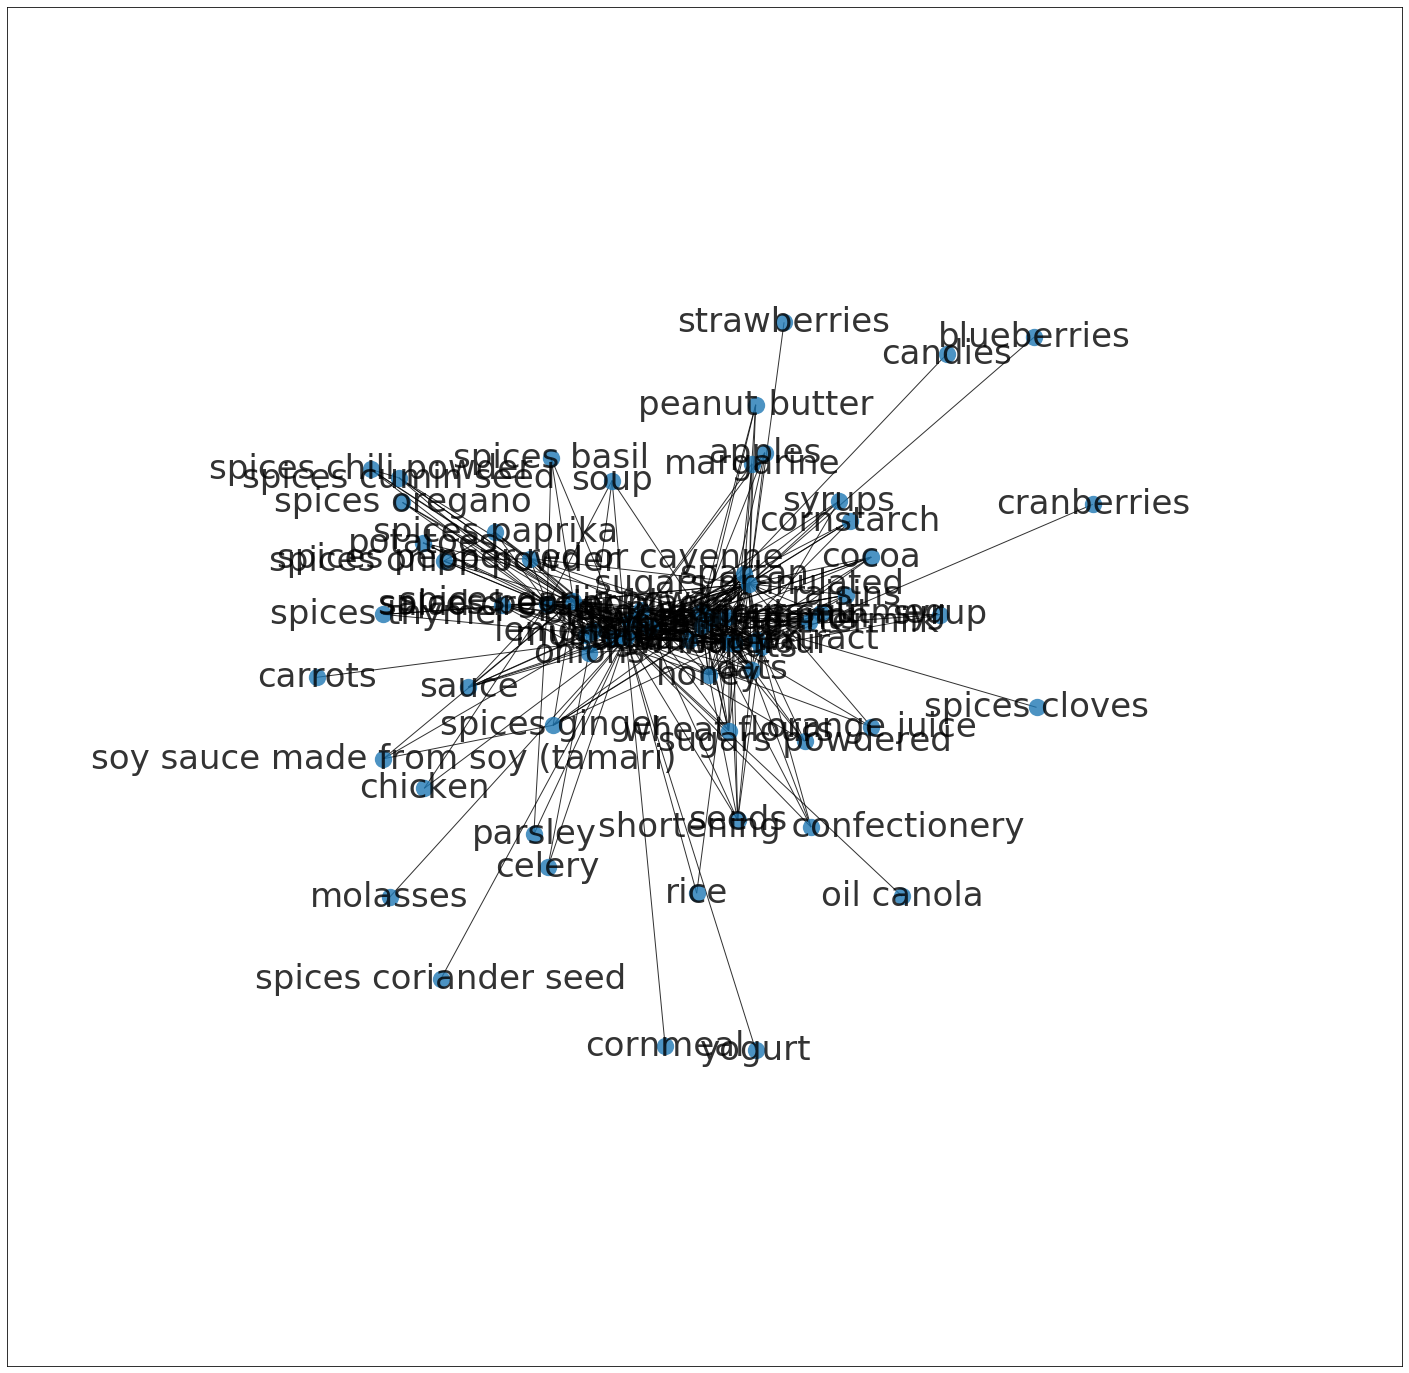

In [13]:
fig, axis = plt.subplots(1, 1, figsize=(25, 25))
nx.draw_networkx(ingredients_graph_top_weight, ax=axis, nodelist=nodes_left, labels=ingredients_df.to_dict()['name'], node_size=300, font_size=34, alpha=0.8, linewidths=0.01)

In [14]:
print(f'Filtered graph -> Number of nodes: {ingredients_graph_top_weight.number_of_nodes()}, Number of edges: {ingredients_graph_top_weight.number_of_edges()}')
print(f'Filtered graph -> Number of self-loops: {nx.number_of_selfloops(ingredients_graph_top_weight)}, Number of connected components: {nx.number_connected_components(ingredients_graph_top_weight)}')
print(f'Filtered graph -> Giant component size: {len(max(nx.connected_components(ingredients_graph_top_weight), key=len))}')

Filtered graph -> Number of nodes: 251, Number of edges: 322
Filtered graph -> Number of self-loops: 0, Number of connected components: 185
Filtered graph -> Giant component size: 67


We see that about a quater of the nodes form the giant component of the graph containing only the heaviest 2% of the edges.

### 1.2. Degree Centrality

In [15]:
degree_centrality = nx.degree_centrality(ingredients_graph)
ingredients_centrality = sorted(degree_centrality.items(), key=operator.itemgetter(1), reverse=True)

# Generate id to name mapping for ingredients
ingredients_id_to_val = ingredients_df.to_dict()['name']

for ingredient in ingredients_centrality[:10]:
    print(f"{ingredients_id_to_val[ingredient[0]]} has centrality {ingredient[1]}")    

water has centrality 0.992
salt has centrality 0.98
sugars granulated has centrality 0.9520000000000001
butter without salt has centrality 0.9520000000000001
oil olive has centrality 0.9440000000000001
milk fluid has centrality 0.9400000000000001
nuts has centrality 0.9400000000000001
wheat flour has centrality 0.936
cheese has centrality 0.932
honey has centrality 0.928


As we would have expected, water, salt and sugars have the highest degrees.

### 1.3. Closeness Centrality

In [16]:
closeness_centrality = nx.closeness_centrality(ingredients_graph)
ingredients_cl_centrality = sorted(closeness_centrality.items(), key=operator.itemgetter(1), reverse=True)

for ingredient in ingredients_cl_centrality[:10]:
    print(f"{ingredients_id_to_val[ingredient[0]]} has centrality {ingredient[1]}")

water has centrality 0.9920634920634921
salt has centrality 0.9803921568627451
sugars granulated has centrality 0.9541984732824428
butter without salt has centrality 0.9541984732824428
oil olive has centrality 0.946969696969697
milk fluid has centrality 0.9433962264150944
nuts has centrality 0.9433962264150944
wheat flour has centrality 0.9398496240601504
cheese has centrality 0.9363295880149812
honey has centrality 0.9328358208955224


Unsurprisingly, we get the same ingredients as before in the top 10 closeness centrality values. As these were already mostly directly connected to all other nodes, it makes sense that they also have a large closeness centrality.

### 1.4. Betweenness centrality

In [17]:
betweenness_centrality = nx.betweenness_centrality(ingredients_graph)
ingredients_bt_centrality = sorted(betweenness_centrality.items(), key=operator.itemgetter(1), reverse=True)

for ingredient in ingredients_bt_centrality[:10]:
    print(f"{ingredient[0]}: {ingredients_id_to_val[ingredient[0]]} has centrality {ingredient[1]}")    

70: water has centrality 0.015189097415118324
16: salt has centrality 0.013444051306579581
47: butter without salt has centrality 0.010934546726877862
3: sugars granulated has centrality 0.010733613572896648
14: wheat flour has centrality 0.010602036834054737
63: milk fluid has centrality 0.010028771751129525
62: cheese has centrality 0.009738015664399302
7: oil olive has centrality 0.009656086066861873
75: nuts has centrality 0.009633718636149698
50: honey has centrality 0.009494549552925328


Betweenness tells us that if were to remove an ingredient that would affect the most number of recipes, water would have the most impact, closely followed by salt, butter and sugars.

One way to compute the distances from one node to all the other nodes in an unweighted graph is to create a tree using Breadth-First-search. Breadth-First search will eliminate any cycles and leave us with the shortest paths to each node

Below we created a tree starting with the most important ingredient: Water

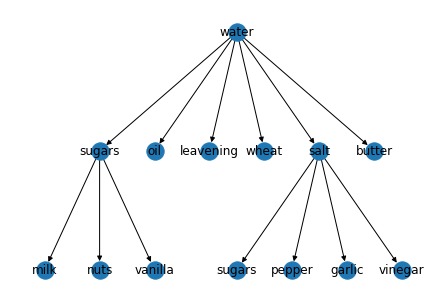

In [18]:
ingredients_graph_raw_top = ingredients_graph_raw.copy()
ingredients_graph_raw_top[ingredients_graph_raw_top < 2400] = 0

ingredients_graph_top_weight = nx.from_numpy_matrix(ingredients_graph_raw_top)
tree = nx.bfs_tree(ingredients_graph_top_weight, 70)
positions = nx.drawing.nx_agraph.graphviz_layout(tree, prog="dot")

all_labels = ingredients_df.to_dict()['name']
filtered_labels = {}
for node in list(tree.nodes):
    crt_label = all_labels[node].split(' ')
    if crt_label[0] == 'spices':
        filtered_labels[node] = crt_label[1]
    else:
        filtered_labels[node] = crt_label[0]
        
nx.draw(tree, positions, labels=filtered_labels, with_labels=True)

Now we are going to remove the heaviest edges.

In [19]:
ingredients_graph_raw_low = ingredients_graph_raw.copy()
ingredients_graph_raw_low[ingredients_graph_raw_low > 200] = 0
ingredients_graph_bottom_weight = nx.from_numpy_matrix(ingredients_graph_raw_low)
print(f'Graph Low Weights -> Number of nodes: {ingredients_graph_bottom_weight.number_of_nodes()}, Number of edges: {ingredients_graph_bottom_weight.number_of_edges()}')
print(f'Graph Low Weights -> Number of self-loops: {nx.number_of_selfloops(ingredients_graph_bottom_weight)}, Number of connected components: {nx.number_connected_components(ingredients_graph_bottom_weight)}')

Graph Low Weights -> Number of nodes: 251, Number of edges: 15157
Graph Low Weights -> Number of self-loops: 0, Number of connected components: 1


In [20]:
betweenness_centrality = nx.degree_centrality(ingredients_graph_bottom_weight)
ingredients_dg_centrality = sorted(betweenness_centrality.items(), key=operator.itemgetter(1), reverse=True)

for ingredient in ingredients_dg_centrality[:10]:
    print(f"{ingredient[0]}: {ingredients_id_to_val[ingredient[0]]} has centrality {ingredient[1]}")

62: cheese has centrality 0.808
51: rice has centrality 0.8
0: yogurt has centrality 0.792
12: orange juice has centrality 0.792
50: honey has centrality 0.788
136: vinegar has centrality 0.788
94: corn has centrality 0.784
29: spices ginger has centrality 0.78
59: lemon juice has centrality 0.78
63: milk fluid has centrality 0.776


We see that the remaining nodes still form one connected component, but the ingredients that were central before lose this position.

### 1.5. Model type
We would like to compare the ingredient graph to similar Erdos-Renyi and Barabasi-Albert graphs. We will try to replicate the number of edges with the two random network models and then compare the degree distributions.

In [21]:
# Get the number of nodes and edges
n = nx.number_of_nodes(ingredients_graph)
m = ingredients_graph.size()

# Compute probability parameter for the Erdos-Renyi model
p = 2 * m / (n * (n - 1))
print(f'Erdos-Renyi probability parameter is {p}.')

# Compute the Barabasi-Albert model parameter
print(f'Maximum number of edges attainable with the Barabasi-Albert model is {int((n / 2)**2)}.')

Erdos-Renyi probability parameter is 0.5098326693227092.
Maximum number of edges attainable with the Barabasi-Albert model is 15750.


We see that we have too many edges, such that we can not generate a Barabasi-Albert model with a comparable number of edges. We will therefore only generate an Erdos-Renyi graph.

In [22]:
# Generate Erdos-Renyi graph
ing_er = nx.erdos_renyi_graph(n, p)
print(f'The number of edges of the Erdos-Renyi model is {ing_er.size()}.')

The number of edges of the Erdos-Renyi model is 15889.


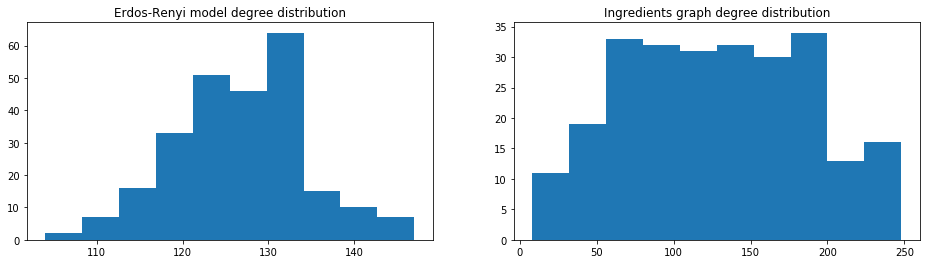

In [23]:
# Compute the degree for the Erdos-Renyi model
ing_er_degree = [degree for node,degree in ing_er.degree()]

# Plot degree distributions
_, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].set_title('Erdos-Renyi model degree distribution')
axes[0].hist(ing_er_degree)
axes[1].set_title('Ingredients graph degree distribution')
axes[1].hist(ing_adj_deg);

In [24]:
print(f'The average clustering coefficient of the ingredients graph is {nx.average_clustering(ingredients_graph)}.')
print(f'The average clustering coefficient of the Erdos-Renyi model is {nx.average_clustering(ing_er)}.')

The average clustering coefficient of the ingredients graph is 0.794286218168331.
The average clustering coefficient of the Erdos-Renyi model is 0.5064668990657388.


Neither the distribution nor the clustering coefficients are close to each other for the Erdos-Renyi model and the ingredient graph. Therefore, we can not categorize our ingredient graph as an Erdos-Renyi model. The ingredient graph has a more uniform degree distribution and better connected neighboring nodes than the Erdos-Renyi model.

## 2. Recipe graph
We now move on to the more interesting graph, the recipe graph. We start by making a similar analysis as for the ingredient graph.

### 2.1. Degree distribution and connected components

Minimum degree in weighted graph is 0.0 for Pitas
Maximum degree in weighted graph is 3713.2495599999993 for Feta Cheese and Olive Bread
Minimum degree in unweighted graph is 0.0 for Pitas
Maximum degree in unweighted graph is 1903.0 for Feta Cheese and Olive Bread


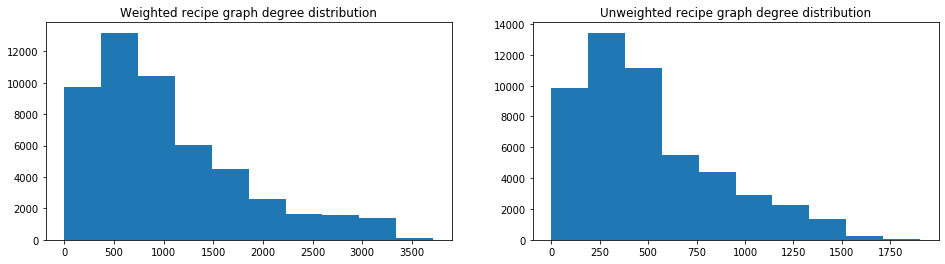

In [25]:
# Form adjacency matrix
recipes_adj = recipes_graph_raw.copy()
recipes_adj[recipes_adj.nonzero()] = 1

recipes_weight_deg = np.asarray(recipes_graph_raw.sum(axis=1)).flatten()
recipes_adj_deg = np.asarray(recipes_adj.sum(axis=1)).flatten()

# Plot degree distributions
_, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Weighted recipe graph degree distribution')
axes[0].hist(recipes_weight_deg)
axes[1].set_title('Unweighted recipe graph degree distribution')
axes[1].hist(recipes_adj_deg);

print(f"Minimum degree in weighted graph is {recipes_weight_deg.min()} for {recipes_df.loc[recipes_weight_deg.argmin()]['name']}")
print(f"Maximum degree in weighted graph is {recipes_weight_deg.max()} for {recipes_df.loc[recipes_weight_deg.argmax()]['name']}")
print(f"Minimum degree in unweighted graph is {recipes_adj_deg.min()} for {recipes_df.loc[recipes_adj_deg.argmin()]['name']}")
print(f"Maximum degree in unweighted graph is {recipes_adj_deg.max()} for {recipes_df.loc[recipes_adj_deg.argmax()]['name']}")

In [26]:
recipes_weight_deg_vals, recipes_weight_deg_counts = np.unique(recipes_weight_deg, return_counts=True)
recipes_adj_deg_vals, recipes_adj_deg_counts = np.unique(recipes_adj_deg, return_counts=True)

recipes_weight_deg_probs = recipes_weight_deg_counts / recipes_weight_deg_counts.sum()
recipes_adj_deg_probs = recipes_adj_deg_counts / recipes_adj_deg_counts.sum()

recipes_weight_moment_1 = (recipes_weight_deg_vals * recipes_weight_deg_probs).sum()
recipes_weight_moment_2 = (recipes_weight_deg_vals**2 * recipes_weight_deg_probs).sum()

recipes_adj_moment_1 = (recipes_adj_deg_vals * recipes_adj_deg_probs).sum()
recipes_adj_moment_2 = (recipes_adj_deg_vals**2 * recipes_adj_deg_probs).sum()

print(f'First moment of weighted graph: {recipes_weight_moment_1}')
print(f'Second moment of weighted graph: {recipes_weight_moment_2}')
print(f'First moment of unweighted graph: {recipes_adj_moment_1}')
print(f'Second moment of unweighted graph: {recipes_adj_moment_2}')

First moment of weighted graph: 1015.7003456324778
Second moment of weighted graph: 1622929.9751304328
First moment of unweighted graph: 499.0896457499756
Second moment of unweighted graph: 382021.45010246907


The recipe graph is not as dense as the ingredient one, as we specifically carried out some downsampling for the number of edges. The degree distributions for the weighted and unweighted graphs have a similar shape with the difference that the item values in the weighted graph are almost double the ones in the unweighted graph. This is due to the fact that most of the entries of the weighted graph have values around 2.

We also note that this time we also encounter isolated nodes.

We would expect the graph of recipes to be connected, but due to the sparsification of the edges, we get plenty of connected components as clusters of the most strongly connected nodes in terms of edge weights.

### 2.2. Nutritional values smoothness
We will look at the smoothness of the nutritional values features in the graph. We will normalize the features, keeping them in range (0,1).

In [27]:
# Compute the laplacian
L = scipy.sparse.diags(np.asarray(recipes_graph_raw.sum(axis=1)).flatten(), 0) - recipes_graph_raw

In [28]:
# Normalize features
feature_names = ['energy', 'fat', 'protein', 'salt', 'saturates', 'sugars']
for feat_name in feature_names:
    feat = recipes_df[feat_name].values.reshape(-1,1)
    feat /= feat.max()
    smoothness = (feat.T @ L @ feat).flatten()[0]
    print(f'Nutritional feature {feat_name} has smoothness {smoothness}.')
print(f'The sum of the edge weights is {recipes_graph_raw.sum()}.')

Nutritional feature energy has smoothness 1087676.1078239377.
Nutritional feature fat has smoothness 989193.2771522792.
Nutritional feature protein has smoothness 168086.4728925312.
Nutritional feature salt has smoothness 202006.66165772703.
Nutritional feature saturates has smoothness 274491.95388097316.
Nutritional feature sugars has smoothness 1173037.6641897564.
The sum of the edge weights is 52039407.208480015.


The smoothest nutritional feature is therefore protein. Also, every feature has a smoothness one or two degrees of magnitude away from that of the worst possible smoothness, namely the sum of the edge weights.

### 2.3. Graph downsampling
This graph takes up too much space, so we will need further downsampling before we proceed with further analysis.

In [29]:
# Sort connected components in terms of size
print(f'The 10 biggest connected components have sizes {sorted([len(cc) for cc in nx.connected_components(recipes_graph)], reverse=True)[:10]}.')

The 10 biggest connected components have sizes [47642, 216, 1, 1, 1, 1, 1, 1, 1, 1].


In [30]:
# Select the giant component
recipes_graph = recipes_graph.subgraph(max(nx.connected_components(recipes_graph), key=len))
recipes_graph_raw = recipes_graph_raw[recipes_graph.nodes()][:, recipes_graph.nodes()]

# Filter out edges
perc90 = np.percentile(recipes_graph_raw[recipes_graph_raw.nonzero()], 90)
recipes_graph_raw = recipes_graph_raw.multiply(recipes_graph_raw >= perc90)
recipes_graph = nx.from_scipy_sparse_matrix(recipes_graph_raw)

# Select the new giant component
recipes_graph = recipes_graph.subgraph(max(nx.connected_components(recipes_graph), key=len))
recipes_graph_raw = nx.to_scipy_sparse_matrix(recipes_graph)

print(f'Filtered graph --> Number of nodes: {recipes_graph.number_of_nodes()}, Number of edges: {recipes_graph.number_of_edges()}')

Filtered graph --> Number of nodes: 28378, Number of edges: 604219


### 2.4. Degree Centrality

In [31]:
degree_centrality = nx.degree_centrality(recipes_graph)
recipes_centrality = sorted(degree_centrality.items(), key=operator.itemgetter(1), reverse=True)

# Generate id to name mapping for ingredients
recipes_id_to_val = recipes_df.to_dict()['name']

for recipe in recipes_centrality[:10]:
    print(f"{recipes_id_to_val[recipe[0]]} has centrality {recipe[1]}")    

Microwave Tablet has centrality 0.013708284878598865
Potato Bread Starter Recipe has centrality 0.013708284878598865
Easy Mexican Bread Pudding has centrality 0.013708284878598865
Fudgsicles (Frozen Fudge Pops) has centrality 0.013708284878598865
Dry Ranch Style Seasoning for Dip or Dressing has centrality 0.013708284878598865
Apple Pie Filling in a Jar has centrality 0.013708284878598865
Buttermilk Dinner Rolls has centrality 0.013708284878598865
Most Delicious Mahogany Glaze has centrality 0.013708284878598865
Icing Drizzle has centrality 0.013708284878598865
Steamed Carrots has centrality 0.013708284878598865


The degree centrality coefficients are fairly low due to the aggresive downsampling that we carried out previously.

Closeness centrality and betweenness centrality take too much time to compute, so we will skip this part.

### 2.5. Model type
We would like to compare the recipe graph to similar Erdos-Renyi and Barabasi-Albert graphs. We will try to replicate the number of edges with the two random network models and then compare the degree distributions.

In [32]:
# Get the number of nodes and edges
n = nx.number_of_nodes(recipes_graph)
m = recipes_graph.size()

# Compute probability parameter for the Erdos-Renyi model
p = 2 * m / (n * (n - 1))
print(f'Erdos-Renyi probability parameter is {p}.')

# Compute the Barabasi-Albert model parameter
print(f'Maximum number of edges attainable with the Barabasi-Albert model is {int((n / 2)**2)}.')

Erdos-Renyi probability parameter is 0.001500638584591331.
Maximum number of edges attainable with the Barabasi-Albert model is 201327721.


This time we can generate both Erdos-Renyi and Barabasi-Albert models.

In [33]:
# Generate Erdos-Renyi graph
recipes_er = nx.erdos_renyi_graph(n, p)
print(f'The number of edges of the Erdos-Renyi model is {recipes_er.size()}.')

# Generate Barabasi-Albert graph
q = int((n - np.sqrt(n**2 - 4 * m)) / 2)
if np.abs(m - q * (n - 1)) > np.abs(m - (q - 1) * (n - q + 1)) and \
    np.abs(m - (q + 1) * (n - q - 1)) > np.abs(m - (q - 1) * (n - q + 1)):
    q -= 1
elif np.abs(m - q * (n - 1)) > np.abs(m - (q + 1) * (n - q - 1)) and \
    np.abs(m - (q - 1) * (n - q + 1)) > np.abs(m - (q + 1) * (n - q - 1)):
    q += 1

recipes_ba = nx.barabasi_albert_graph(n, q)
print(f'The number of edges of the Barabasi-Albert model is {recipes_ba.size()}.')

The number of edges of the Erdos-Renyi model is 605443.
The number of edges of the Barabasi-Albert model is 595497.


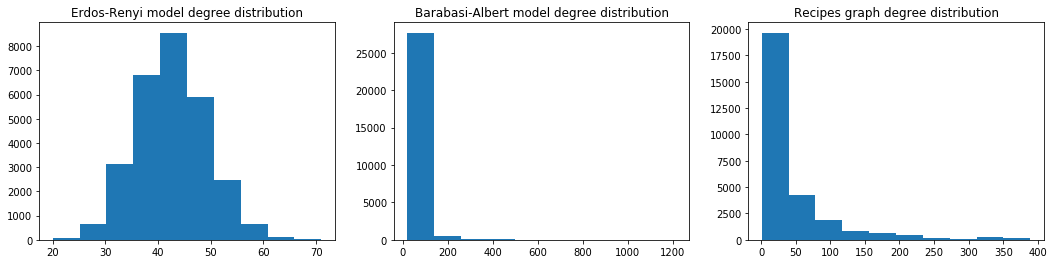

In [34]:
recipes_adj = recipes_graph_raw.copy()
recipes_adj[recipes_adj.nonzero()] = 1
recipes_adj_deg = np.asarray(recipes_adj.sum(axis=1)).flatten()

# Compute the degree for the Erdos-Renyi and Barabasi-Albert models
recipes_er_degree = [degree for node,degree in recipes_er.degree()]
recipes_ba_degree = [degree for node,degree in recipes_ba.degree()]

# Plot degree distributions
_, axes = plt.subplots(1, 3, figsize=(18,4))
axes[0].set_title('Erdos-Renyi model degree distribution')
axes[0].hist(recipes_er_degree)
axes[1].set_title('Barabasi-Albert model degree distribution')
axes[1].hist(recipes_ba_degree)
axes[2].set_title('Recipes graph degree distribution')
axes[2].hist(recipes_adj_deg);

In [35]:
print(f'The average clustering coefficient of the recipe graph is {nx.average_clustering(recipes_graph)}.')
print(f'The average clustering coefficient of the Erdos-Renyi model is {nx.average_clustering(recipes_er)}.')
print(f'The average clustering coefficient of the Barabasi-Albert model is {nx.average_clustering(recipes_ba)}.')

The average clustering coefficient of the recipe graph is 0.5905776558085756.
The average clustering coefficient of the Erdos-Renyi model is 0.0015339082787133855.
The average clustering coefficient of the Barabasi-Albert model is 0.008237966650067624.


The clustering coefficient is a lot higher for the recipes graph than for both the Erdos-Renyi and Barabasi-Albert models. Therefore, we, again, we can not include our recipe graph in any of these two random-graph model categories. However, the degree distribution has a pretty scale-free figure.